# Requirement:
- numpy 1.19.5
- tensorflow 2.5.0
- tensorflow_privacy 0.6.1
- sklearn 0.24.2

Before performing the experiments, you need to fit the **pickle_file**(path for tabular QMNIST data) according to your own PC.

In [1]:
import numpy as np

import pickle
import tensorflow as tf
from tensorflow.keras import layers
import random as python_random

from sklearn.model_selection import train_test_split

# Load QMNIST data.

In [2]:
pickle_file = '/home/jiangnan/Desktop/ppml-workshop/data/QMNIST_tabular_ppml.pickle'

with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  x_defender = pickle_data['x_defender']
  x_reserve = pickle_data['x_reserve']
  y_defender = pickle_data['y_defender']
  y_reserve = pickle_data['y_reserve']
  del pickle_data
print('Data loaded.')

Data loaded.


In [3]:
NUM_CLASSES = 10

y_defender = y_defender[:,0]
y_reserve = y_reserve[:,0]

#y_defender = np.expand_dims(y_defender,axis=1)
#y_reserve = np.expand_dims(y_reserve,axis=1)

#y_defender = tf.keras.utils.to_categorical(y_defender, num_classes=NUM_CLASSES)
#y_reserve = tf.keras.utils.to_categorical(y_reserve, num_classes=NUM_CLASSES)

# Defender model $M_D$

import the defender model which need to be tested.

In [4]:
from sklearn.naive_bayes import GaussianNB

def defender_model_fn():
    """The architecture of the defender (victim) model.
    The attack is white-box, hence the attacker is assumed to know this architecture too."""

    model = GaussianNB()

    return model

## Train $M_D$ 

In [197]:
number_records = [48, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 200000]

N_RECORDS = 0
number_records_used = number_records[N_RECORDS]

data_in = x_defender[:number_records_used], y_defender[:number_records_used]
data_out = x_reserve[:number_records_used], y_reserve[:number_records_used]

In [198]:
#defender_model_path = '/home/jiangnan/Desktop/ppml-workshop/defender_trained_models/simple_fn_48examples'
#defender_model = tf.keras.models.load_model(defender_model_path)

In [199]:
defender_model = defender_model_fn()
defender_model.fit(data_in[0],data_in[1])

GaussianNB()

## Evaluate the utility of $M_D$ on utility evaluation dataset $E_U$ (which is equal to reserve dataset $R$).

Evaluation metrics: **Accuracy** & **AUC**

In [200]:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

In [201]:
predict_reserve_proba = defender_model.predict_proba(data_out[0])
predict_reserve = np.argmax(predict_reserve_proba, axis=1)
acc = accuracy_score(data_out[1], predict_reserve)
#loss = log_loss(data_out[1], predict_reserve_proba)

In [202]:
auc_by_class = []

# compute auc per class then take the average value
for i in range(NUM_CLASSES):
  class_indices = data_out[1] == i
  if np.sum(class_indices) == 0:
        continue
  fpr, tpr, thresholds = metrics.roc_curve(class_indices, predict_reserve_proba[:,i])
  auc = metrics.auc(fpr, tpr)
  auc_by_class.append(auc)

average_auc = np.mean(auc_by_class)

In [203]:
print('Utility of defender model:')
print('Acc: {}'.format(acc))
print('Auc: {}'.format(average_auc))
#print('Loss: {}'.format(loss))

Utility of defender model:
Acc: 0.6666666666666666
Auc: 0.7689347200700154


In [204]:
utility = max(2*average_auc -1,0)
print('Defender model utility: {}'.format(utility))

Defender model utility: 0.5378694401400308


# Oracle attack model $M_A$

In [205]:
import random
from tqdm import tqdm

In [228]:
def create_mock_defender_models(defender = defender_model, data_in = data_in, data_out = data_out, n_records = 48, random_select = True, n_extract = 100, given_index = False):
    
    similarities_in = []
    similarities_out = []
    
    number_loop = 0
    
    if random_select == True:
        number_loop = n_extract
    else:
        number_loop = data_in[0].shape[0]
        
    for i in tqdm(range(number_loop)):

        if random_select == True:
            index = random.randint(0,n_records-1)
        else:
            index = i

        evaluation_data_in = data_in[0][index]
        evaluation_label_in = data_in[1][index]

        evaluation_data_out = data_out[0][index]
        evaluation_label_out = data_out[1][index]

        evaluation_data = np.array([evaluation_data_in, evaluation_data_out])
        evaluation_label = np.array([evaluation_label_in, evaluation_label_out])

        evaluation = evaluation_data, evaluation_label


        attack_train_data_in = np.delete(data_in[0], index, axis=0)
        attack_train_label_in = np.delete(data_in[1], index, axis=0)

        attack_in = attack_train_data_in, attack_train_label_in


        attack_train_data_out = np.delete(data_out[0], index, axis=0)
        attack_train_label_out = np.delete(data_out[1], index, axis=0)

        attack_out = attack_train_data_out, attack_train_label_out


        predict = defender_model.predict_log_proba(attack_in[0])

        
        if given_index == True:

            attack_in_plus_one_in = np.insert(attack_in[0], index, evaluation[0][0].reshape(1,attack_in[0].shape[1]), axis=0), np.insert(attack_in[1], index, evaluation[1][0], axis=0)
            attack_in_plus_one_out = np.insert(attack_in[0], index, evaluation[0][1].reshape(1,attack_in[0].shape[1]), axis=0), np.insert(attack_in[1], index, evaluation[1][1], axis=0)

        else:

            attack_in_plus_one_in = np.vstack((evaluation[0][0].reshape(1,attack_in[0].shape[1]),attack_in[0])), np.hstack(( evaluation[1][0],attack_in[1]))
            attack_in_plus_one_out = np.vstack((evaluation[0][1].reshape(1,attack_in[0].shape[1]),attack_in[0])), np.hstack(( evaluation[1][1],attack_in[1]))

        
        M_cD_in = defender_model_fn()
        M_cD_out = defender_model_fn()

        M_cD_in.fit(attack_in_plus_one_in[0], attack_in_plus_one_in[1])
        M_cD_out.fit(attack_in_plus_one_out[0], attack_in_plus_one_out[1])

        M_cD_in_predict = M_cD_in.predict_log_proba(attack_in[0])
        M_cD_out_predict = M_cD_out.predict_log_proba(attack_in[0])

        similarity_in = np.mean(np.linalg.norm(M_cD_in_predict-predict, axis=1))
        similarity_out = np.mean(np.linalg.norm(M_cD_out_predict-predict, axis=1))

        similarities_in.append(similarity_in)
        similarities_out.append(similarity_out)
    
    return similarities_in, similarities_out


In [ ]:
n_records = number_records[N_RECORDS]
random_select = False
n_extract = 100
given_index = False

similarities_in, similarities_out = create_mock_defender_models(defender = defender_model,
                                                                data_in = data_in,
                                                                data_out = data_out,
                                                                n_records = n_records,
                                                                random_select = random_select,
                                                                n_extract = n_extract,
                                                                given_index = given_index)

In [229]:
random_select = False
n_extract = 100
given_index = False

similarities_in_all = []
similarities_out_all = []

number_records = [48, 100, 200, 400, 800, 1600, 3200, 6400]

for n_records in number_records:
    
    data_in = x_defender[:n_records], y_defender[:n_records]
    data_out = x_reserve[:n_records], y_reserve[:n_records]
    defender_model = defender_model_fn()
    defender_model.fit(data_in[0],data_in[1])
    
    similarities_in, similarities_out = create_mock_defender_models(defender = defender_model,
                                                                    data_in = data_in,
                                                                    data_out = data_out,
                                                                    n_records = n_records,
                                                                    random_select = random_select,
                                                                    n_extract = n_extract,
                                                                    given_index = given_index)
    
    similarities_in_all.append(similarities_in)
    similarities_out_all.append(similarities_out)

100%|██████████| 6400/6400 [1:12:54<00:00,  1.46it/s]


In [234]:
utility_all = []

for n_records in number_records:
    data_in = x_defender[:n_records], y_defender[:n_records]
    data_out = x_reserve[:n_records], y_reserve[:n_records]
    defender_model = defender_model_fn()
    defender_model.fit(data_in[0],data_in[1])
    predict_reserve_proba = defender_model.predict_proba(data_out[0])
    
    auc_by_class = []

    # compute auc per class then take the average value
    for i in range(NUM_CLASSES):
      class_indices = data_out[1] == i
      if np.sum(class_indices) == 0:
            continue
      fpr, tpr, thresholds = metrics.roc_curve(class_indices, predict_reserve_proba[:,i])
      auc = metrics.auc(fpr, tpr)
      auc_by_class.append(auc)

    average_auc = np.mean(auc_by_class)
    utility = max(2*average_auc -1,0)
    utility_all.append(utility)

In [231]:
privacy_all = []
variance_all = []
sigma_error_all = []

for i in range(len(similarities_in_all)):
    
    similarities_in = similarities_in_all[i]
    similarities_out = similarities_out_all[i]
    
    results = []

    for j in tqdm(range(len(similarities_in))):
        for k in range(len(similarities_out)):

            if similarities_in[j] <= similarities_out[k]:
                results.append(1)
            else:
                results.append(0)

    n = len(results)
    p = 1-np.sum(results)/n

    privacy = min(2*p,1)
    variance = 2*p*(1-p)/n
    sigma_error = 2*np.sqrt(p*(1-p)/n)
    
    privacy_all.append(privacy)
    variance_all.append(variance)
    sigma_error_all.append(sigma_error)
    

100%|██████████| 6400/6400 [00:07<00:00, 914.17it/s]


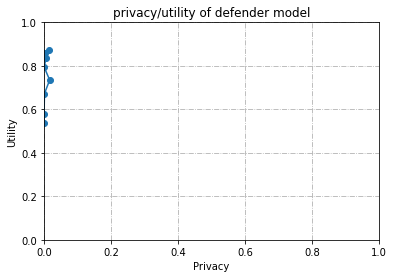

In [247]:
import matplotlib.pyplot as plt

plt.figure()
plt.grid(linestyle='-.',)
#plt.plot(acc,auc,yerr=[auc_max-auc,auc-auc_min],c='lightskyblue',marker='o',label='train acc')
plt.plot(privacy_all,utility_all,marker='o')
plt.title("privacy/utility of defender model")
plt.xlabel('Privacy')
plt.ylabel('Utility')

plt.xlim((0,1))
plt.ylim((0,1))
#plt.legend()
plt.show()

In [227]:
print('Percentage of wrong guess: {} %'.format(p*100))
print('Defender model privacy: {}'.format(privacy))
print('Privacy variance: {}'.format(variance))
print('Privacy error: {}'.format(sigma_error))

Percentage of wrong guess: 0.0 %
Defender model privacy: 0.0
Privacy variance: 0.0
Privacy error: 0.0
